# Environment

#### Hypatia
* virtual env: source envs/pSEOBNRv4HM_tgr_injections/bin/activate
* lalsuite: source $VIRTUAL_ENV/opt/lalsuite_pSEOBNRv4HM_tgr_injection/etc/lal*.sh

#### Laptop
* virtual env: pyenv activate pSEOBNRv4HM_tgr_injections
* lalsuite: source .pyenv/versions/pSEOBNRv4HM_tgr_injections/opt/lalsuite_pSEOBNRv4HM_tgr_injection_20201106_d16da559/etc/lalsuiterc 

In [12]:
#%matplotlib notebook
import os

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator,AutoMinorLocator
from scipy.ndimage import gaussian_filter
from scipy.interpolate import CubicSpline
from scipy.stats import gaussian_kde
import pandas as pd
import corner

import lal
import lalsimulation as lalsim

import sys
sys.path.insert(0,'code')
sys.path.append('../../scripts')

import compute_sigmalm0_SimIMREOBGenerateQNMFreqV2 as calcqnm
import scipy
import scipy.signal as ss
from scipy import interpolate
import scipy.ndimage.filters as filter
from optparse import OptionParser
import glob
import h5py
import seaborn as sns

from bounded_1d_kde import Bounded_1d_kde
from bounded_2d_kde import Bounded_2d_kde


plt.style.use("MATPLOTLIB_RCPARAMS.sty") 

In [13]:
plt.style.use("MATPLOTLIB_RCPARAMS.sty")  # I dont know why but I need to put this twice for it to kick in

### Functions

In [88]:
# Module for confidence calculations
class confidence(object):
    def __init__(self, counts):
        # Sort in descending order in frequency
        self.counts_sorted = np.sort(counts.flatten())[::-1]
        # Get a normalized cumulative distribution from the mode
        self.norm_cumsum_counts_sorted = np.cumsum(self.counts_sorted) / np.sum(counts)
        # Set interpolations between heights, bins and levels
        self._set_interp()
    def _set_interp(self):
        self._length = len(self.counts_sorted)
        # height from index
        self._height_from_idx = interpolate.interp1d(np.arange(self._length), self.counts_sorted, bounds_error=False, fill_value=0.)
        # index from height
        self._idx_from_height = interpolate.interp1d(self.counts_sorted[::-1], np.arange(self._length)[::-1], bounds_error=False, fill_value=self._length)
        # level from index
        self._level_from_idx = interpolate.interp1d(np.arange(self._length), self.norm_cumsum_counts_sorted, bounds_error=False, fill_value=1.)
        # index from level
        self._idx_from_level = interpolate.interp1d(self.norm_cumsum_counts_sorted, np.arange(self._length), bounds_error=False, fill_value=self._length)
    def level_from_height(self, height):
        return self._level_from_idx(self._idx_from_height(height))
    def height_from_level(self, level):
        return self._height_from_idx(self._idx_from_level(level))

# gaussian filter of histogram
def gf(P):
    return filter.gaussian_filter(P, sigma=2.0)

# construct effective quantities from PE samples
def eff_quant(m1, m2, a1z, a2z, domega, dtau, lm):
    omega_GR, tau_GR = calcqnm.get_sigmalm0SI_GR(m1, m2, a1z, a2z, lm)
    freq_GR = omega_GR/(2.*np.pi)

    omega_modGR, tau_modGR = calcqnm.get_sigmalm0SI_modGR(omega_GR, tau_GR, domega, dtau)
    freq_modGR = omega_modGR/(2.*np.pi)
    
    return freq_GR, tau_GR, freq_modGR, tau_modGR

# using fitting formulas from https://arxiv.org/pdf/gr-qc/0512160.pdf
# to get final mass and final spin from omega220 and tau220.
# See eqs.2.1, E1 and E2, and table VIII for fitting coefficients

def Mjfinal220(omega220,tau220):

    jf=1-pow((omega220*tau220/2.-0.7)/(1.4187),-1/0.4990)
    Mf=((1.5251 - 1.1568*pow((1 - jf),0.1292))/omega220)*(pow(lal.C_SI,3)/lal.G_SI/lal.MSUN_SI)

    return Mf,jf

# 2D histogram
def P_xy_2dhist(x, y, N_bins):
    x_bins = np.linspace(min(x), max(x), N_bins)
    y_bins = np.linspace(min(y), max(y), N_bins)

    dx = np.mean(np.diff(x_bins))
    dy = np.mean(np.diff(y_bins))

    x_intp = (x_bins[:-1] + x_bins[1:])/2.
    y_intp = (y_bins[:-1] + y_bins[1:])/2.
    
    P_xy, x_bins, y_bins = np.histogram2d(x, y, bins=(x_bins, y_bins), normed=True)
    P_xy = P_xy.T
    
    conf = confidence(P_xy)
    s1 = conf.height_from_level(0.5)
    s2 = conf.height_from_level(0.9)
    
    P_x = np.sum(P_xy, axis=0) * dy
    P_y = np.sum(P_xy, axis=1) * dx
    
    return P_xy, P_x, P_y, x_intp, y_intp, s1, s2

def read_samples_from_filename(filename):    
    data=pd.read_hdf(filename)
    return data


def make_nice_plot(p1_samples, p2_samples, file_name, p1_bins=np.linspace(-1,1,1000), \
                   p2_bins=np.linspace(-1,1,1000), params=['domega220','dtau220'], \
                   p1_inj=0., p2_inj=0., color='red', label='pSEOBNRv4HM', \
                   axeslabels=[r'$\delta f_{\text{220}}$',r'$\delta \\tau _{\text{220}}$']):
    
    import matplotlib.gridspec as gridspec
    show_hist=False # For debugging -- set this to true to show the histogram to check the kde isn't lying

    # parameters to plot
    params=params
    
    # colors and labels for two injections
    color = color
    label = label

    # short hand for parameters used later
    p1=params[0]
    p2=params[1]
    
    truths={p1:p1_inj, p2:p2_inj}

    # create figure and axes
    fig,axes=plt.subplots(2,2,facecolor='white')
    gs=gridspec.GridSpec(2,2,width_ratios=[4,1],height_ratios=[1,4],wspace=0,hspace=0)
    p1_axis=plt.subplot(gs[0])
    p2_axis=plt.subplot(gs[3])
    p1p2_axis=plt.subplot(gs[2])

    # axis limits for plots
    # Take the min of m1 and max of m2 axes to be the largest sample (represents m1=m2 border)
    # The other boundaries are set by hand for aesthetics
    xmin_p1=min(p1_samples)
    xmax_p1=max(p1_samples)
    xmin_p2=min(p2_samples)
    xmax_p2=max(p2_samples)
    xlims={p1:(xmin_p1,xmax_p1), p2:(xmin_p2,xmax_p2)}
    
    # p1 1d-histogram
    ax=p1_axis
    if show_hist:
        _=ax.hist(p1_samples,density=True,bins=100,alpha=0.2,color='black')
    kde=Bounded_1d_kde(p1_samples,xlow=min(p1_samples))
    ax.fill_between(p1_bins,0,kde(p1_bins),color=color,alpha=0.5)
    ax.plot(p1_bins,kde(p1_bins),color=color,linewidth=2)
    ax.axvline(np.percentile(p1_samples,5),linestyle='--',linewidth=2,color=color)
    ax.axvline(np.percentile(p1_samples,95),linestyle='--',linewidth=2,color=color)  
    ax.axvline(truths[p1],color='black') 
    ax.set_ylim(bottom=0)
    ax.set_xlim(xlims[p1])
    ax.set_yticklabels([])
    ax.tick_params(bottom=True,left=False,right=False,top=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # p2 1d-histogram
    ax=p2_axis
    if show_hist:
        _=ax.hist(p2_samples,density=True,bins=100,alpha=0.2,color='black',orientation='horizontal')
    kde=Bounded_1d_kde(p2_samples,xhigh=max(p2_samples))
    ax.fill_betweenx(p2_bins,0,kde(p2_bins),color=color,alpha=0.5)
    ax.plot(kde(p2_bins),p2_bins,color=color,linewidth=2)
    ax.axhline(np.percentile(p2_samples,5),linestyle='--',linewidth=2,color=color)
    ax.axhline(np.percentile(p2_samples,95),linestyle='--',linewidth=2,color=color)  
    ax.axhline(truths[p2],color='black') 
    ax.set_xlim(left=0)
    ax.set_ylim(xlims[p2])
    ax.set_xticklabels([])
    ax.tick_params(bottom=False,left=False,right=False,top=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # p1-p2 2d histogram
    corner.hist2d(p1_samples,p2_samples,color=color,
                  ax=p1p2_axis,
                 levels=[0.9],plot_density=True,bins=100,smooth=2.0)
    p1p2_axis.plot(-1,-1,linewidth=2,alpha=1,color=color,label=label) # fake points to make legend
    p1p2_axis.set_xlim(xlims[p1])
    p1p2_axis.set_ylim(xlims[p2])
    p1p2_axis.axvline(truths[p1],color='black')
    p1p2_axis.axhline(truths[p2],color='black')
    p1p2_axis.set_xlabel(axeslabels[0])
    p1p2_axis.set_ylabel(axeslabels[1])
    p1p2_axis.scatter(truths[p1],truths[p2],color='black',marker='s',linewidth=5,zorder=100)

    # put on ticks
    ax=p1p2_axis
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(axis="x",which='minor',length=5,bottom=True,left=True,top=True,right=True,direction='in')
    ax.tick_params(axis="y",which='minor',length=5,bottom=True,left=True,top=True,right=True,direction='in')
    ax.tick_params(axis="x",which='major',length=10,labelsize=25,bottom=True,left=True,top=True,right=True,direction='in')
    ax.tick_params(axis="y",which='major',length=10,labelsize=25,bottom=True,left=True,top=True,right=True,direction='in')

    # turn off the border for the 1d histograms
    ax.legend(loc=1,frameon=False) 

    # save the plot
    fig.subplots_adjust(wspace=0)
    fig.subplots_adjust(hspace=0)
    plt.tight_layout() # avoids overlapping labels
    plt.savefig(file_name,bbox_inches='tight') 
    
    return None

def make_nice_plot_comparison(p1_samples_stack, p2_samples_stack, file_name, p1_bins=np.linspace(-1,1,1000), \
                   p2_bins=np.linspace(-1,1,1000), params=['domega220','dtau220'], \
                   p1_inj=[0.,0.], p2_injs=[0.,0.], colors=['red','blue'], labels=['pSEOB','SEOB'], \
                   axeslabels=[r'$\delta f_{\text{220}}$',r'$\delta \\tau _{\text{220}}$']):
    
    import matplotlib.gridspec as gridspec
    show_hist=False # For debugging -- set this to true to show the histogram to check the kde isn't lying

    # parameters to plot
    params=params
    
    # colors and labels for two injections
    color = colors
    label = labels

    # short hand for parameters used later
    p1=params[0]
    p2=params[1]
    
    truths={p1:p1_inj, p2:p2_inj}

    # create figure and axes
    fig,axes=plt.subplots(2,2,facecolor='white')
    gs=gridspec.GridSpec(2,2,width_ratios=[4,1],height_ratios=[1,4],wspace=0,hspace=0)
    p1_axis=plt.subplot(gs[0])
    p2_axis=plt.subplot(gs[3])
    p1p2_axis=plt.subplot(gs[2])

    # axis limits for plots
    # Take the min of m1 and max of m2 axes to be the largest sample (represents m1=m2 border)
    # The other boundaries are set by hand for aesthetics
    xmin_p1=min(p1_samples)
    xmax_p1=max(p1_samples)
    xmin_p2=min(p2_samples)
    xmax_p2=max(p2_samples)
    xlims={p1:(xmin_p1,xmax_p1), p2:(xmin_p2,xmax_p2)}
    
    # p1 1d-histogram
    ax=p1_axis
    if show_hist:
        _=ax.hist(p1_samples,density=True,bins=100,alpha=0.2,color='black')
    kde=Bounded_1d_kde(p1_samples,xlow=min(p1_samples))
    ax.fill_between(p1_bins,0,kde(p1_bins),color=color,alpha=0.5)
    ax.plot(p1_bins,kde(p1_bins),color=color,linewidth=2)
    ax.axvline(np.percentile(p1_samples,5),linestyle='--',linewidth=2,color=color)
    ax.axvline(np.percentile(p1_samples,95),linestyle='--',linewidth=2,color=color)  
    ax.axvline(truths[p1],color='black') 
    ax.set_ylim(bottom=0)
    ax.set_xlim(xlims[p1])
    ax.set_yticklabels([])
    ax.tick_params(bottom=True,left=False,right=False,top=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # p2 1d-histogram
    ax=p2_axis
    if show_hist:
        _=ax.hist(p2_samples,density=True,bins=100,alpha=0.2,color='black',orientation='horizontal')
    kde=Bounded_1d_kde(p2_samples,xhigh=max(p2_samples))
    ax.fill_betweenx(p2_bins,0,kde(p2_bins),color=color,alpha=0.5)
    ax.plot(kde(p2_bins),p2_bins,color=color,linewidth=2)
    ax.axhline(np.percentile(p2_samples,5),linestyle='--',linewidth=2,color=color)
    ax.axhline(np.percentile(p2_samples,95),linestyle='--',linewidth=2,color=color)  
    ax.axhline(truths[p2],color='black') 
    ax.set_xlim(left=0)
    ax.set_ylim(xlims[p2])
    ax.set_xticklabels([])
    ax.tick_params(bottom=False,left=False,right=False,top=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # p1-p2 2d histogram
    corner.hist2d(p1_samples,p2_samples,color=color,
                  ax=p1p2_axis,
                 levels=[0.9],plot_density=True,bins=100,smooth=2.0)
    p1p2_axis.plot(-1,-1,linewidth=2,alpha=1,color=color,label=label) # fake points to make legend
    p1p2_axis.set_xlim(xlims[p1])
    p1p2_axis.set_ylim(xlims[p2])
    p1p2_axis.axvline(truths[p1],color='black')
    p1p2_axis.axhline(truths[p2],color='black')
    p1p2_axis.set_xlabel(axeslabels[0])
    p1p2_axis.set_ylabel(axeslabels[1])
    p1p2_axis.scatter(truths[p1],truths[p2],color='black',marker='s',linewidth=5,zorder=100)

    # put on ticks
    ax=p1p2_axis
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(axis="x",which='minor',length=5,bottom=True,left=True,top=True,right=True,direction='in')
    ax.tick_params(axis="y",which='minor',length=5,bottom=True,left=True,top=True,right=True,direction='in')
    ax.tick_params(axis="x",which='major',length=10,labelsize=25,bottom=True,left=True,top=True,right=True,direction='in')
    ax.tick_params(axis="y",which='major',length=10,labelsize=25,bottom=True,left=True,top=True,right=True,direction='in')

    # turn off the border for the 1d histograms
    ax.legend(loc=1,frameon=False) 

    # save the plot
    fig.subplots_adjust(wspace=0)
    fig.subplots_adjust(hspace=0)
    plt.tight_layout() # avoids overlapping labels
    plt.savefig(file_name,bbox_inches='tight') 
    
    return None

# Software Injections: GR/nonGR

In [18]:
# data

event_list = ['GW150914', 'GW190521']
run_list = ['0p0', '0p5', '0p0_GR', '0p5_GR']

data_dict = {}

for event in event_list:
    data_dict[event] = {}
    
    for run in run_list:
        
        data_loc = glob.glob('../../runs/nonGR/%s-like/*_%s_widerdist/cbcBayes/posterior_samples.dat'%(event, run))[0]
        data_dict[event][run] = np.genfromtxt(data_loc, dtype=None, names=True)

## GW150914

### 0p0: pSEOB

The injected values are for freq_GR, tau_GR, freq_modGR, tau_modGR, Mf, af are:  [246.80589509] [4.13815066] [246.80589509] [4.13815066] [68.99845755] [0.68089317]


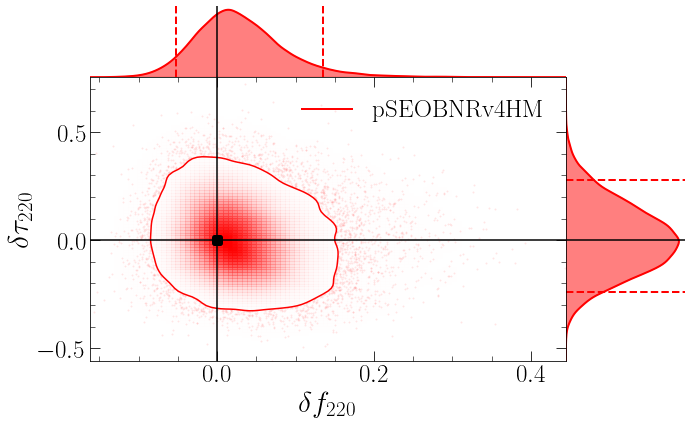

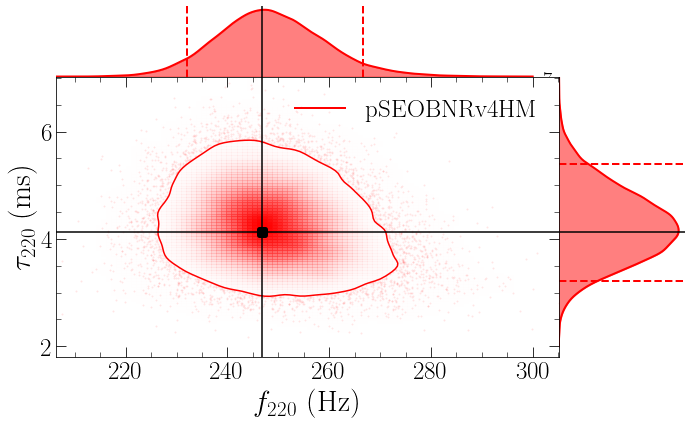

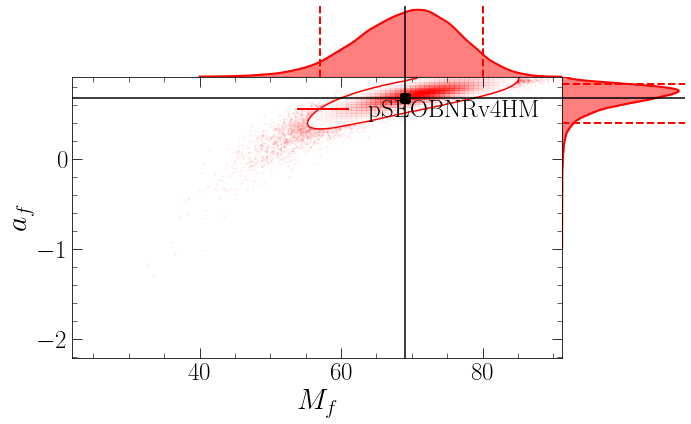

In [87]:
m1_inj, m2_inj, a1z_inj, a2z_inj = 38.528614, 33.400536, 0.003469902, -0.04400404
freq_GR_inj, tau_GR_inj, freq_modGR_inj, tau_modGR_inj = eff_quant(np.array([m1_inj]), \
                                                                   np.array([m2_inj]), \
                                                                   np.array([a1z_inj]), \
                                                                   np.array([a2z_inj]), \
                                                                   0.0, 0.0, [2,2])
Mf_inj, af_inj = Mjfinal220(2.*np.pi*freq_modGR_inj,tau_modGR_inj)

tau_GR_inj *= 1000.
tau_modGR_inj *= 1000.


print("The injected values are for freq_GR, tau_GR, freq_modGR, tau_modGR, Mf, af are: ",\
      freq_GR_inj, tau_GR_inj, freq_modGR_inj, tau_modGR_inj, Mf_inj, af_inj)

# read data
data = data_dict['GW150914']['0p0']

# read out the specific columns: m1,m2,a1z,a2z,domega220,dtau220
m1, m2, a1z, a2z, domega, dtau = data["m1"], data["m2"], data["a1z"], data["a2z"], data["domega220"], data["dtau220"]

# construct the frequencies and damping times
freq_GR, tau_GR, freq_modGR, tau_modGR = eff_quant(m1, m2, a1z, a2z, domega, dtau, [2,2])

# construct the final mass and spin
Mf, af = Mjfinal220(2.*np.pi*freq_modGR,tau_modGR)

# converty damping time samples from second to milli-second
tau_GR *= 1000.
tau_modGR *= 1000.

make_nice_plot(domega, dtau, file_name='./figures/GW150914_simulated_signal_0p0_deltaf220_deltatau220.png',\
                   p1_bins=np.linspace(-1,1,1000), \
                   p2_bins=np.linspace(-1,1,1000), params=['domega220','dtau220'], \
                   p1_inj=0., p2_inj=0., color='red', label='pSEOBNRv4HM',\
                   axeslabels=['$\delta f _{220}$','$\delta \\tau _{220}$'])

make_nice_plot(freq_modGR, tau_modGR, file_name='./figures/GW150914_simulated_signal_0p0_f220_tau220.png',\
                   p1_bins=np.linspace(200,300,1000), \
                   p2_bins=np.linspace(2,8,1000), params=['domega220','dtau220'], \
                   p1_inj=freq_modGR_inj, p2_inj=tau_modGR_inj, color='red', label='pSEOBNRv4HM',\
                   axeslabels=['$f _{220}$ (Hz)','$\\tau _{220}$ (ms)'])

make_nice_plot(Mf, af, file_name='./figures/GW150914_simulated_signal_0p0_Mfaf.png',\
                   p1_bins=np.linspace(40,100, 1000), \
                   p2_bins=np.linspace(-1,1,1000), params=['domega220','dtau220'], \
                   p1_inj=Mf_inj, p2_inj=af_inj, color='red', label='pSEOBNRv4HM',\
                   axeslabels=['$M_f/M_\odot$','$a_f$'])

### 0p5: pSEOB

The injected values are for freq_GR, tau_GR, freq_modGR, tau_modGR, Mf, af are:  [246.80589509] [4.13815066] [370.20884264] [6.20722599] [65.08383884] [0.95293191]


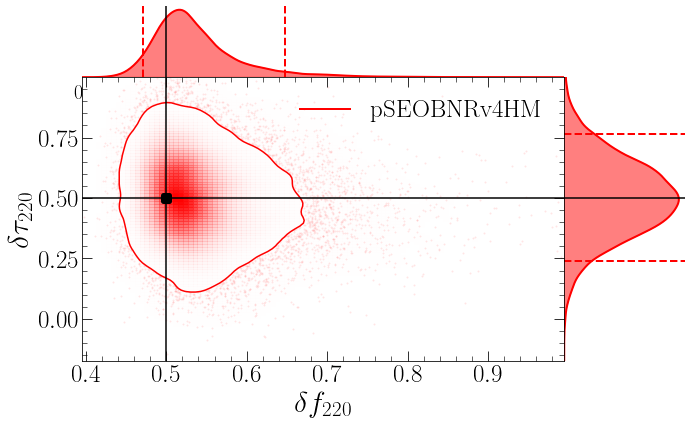

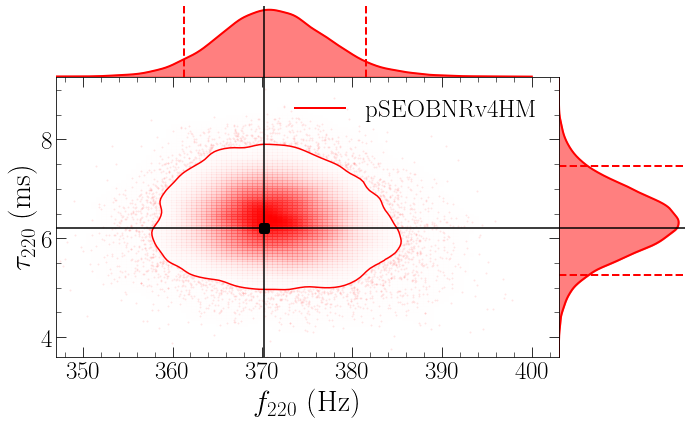

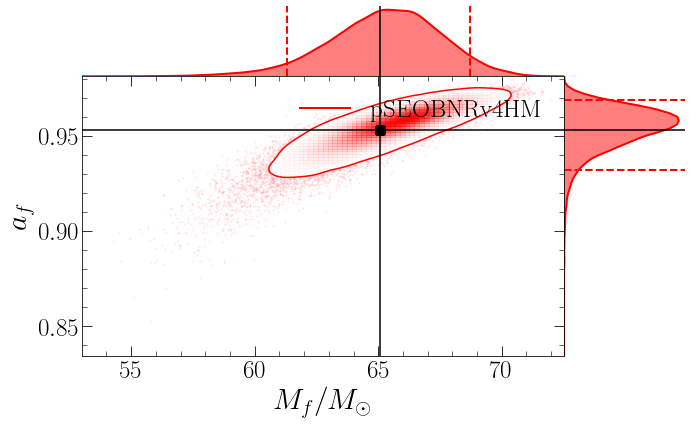

In [90]:
m1_inj, m2_inj, a1z_inj, a2z_inj = 38.528614, 33.400536, 0.003469902, -0.04400404
freq_GR_inj, tau_GR_inj, freq_modGR_inj, tau_modGR_inj = eff_quant(np.array([m1_inj]), \
                                                                   np.array([m2_inj]), \
                                                                   np.array([a1z_inj]), \
                                                                   np.array([a2z_inj]), \
                                                                   0.5, 0.5, [2,2])
Mf_inj, af_inj = Mjfinal220(2.*np.pi*freq_modGR_inj,tau_modGR_inj)

tau_GR_inj *= 1000.
tau_modGR_inj *= 1000.


print("The injected values are for freq_GR, tau_GR, freq_modGR, tau_modGR, Mf, af are: ",\
      freq_GR_inj, tau_GR_inj, freq_modGR_inj, tau_modGR_inj, Mf_inj, af_inj)

# read data
data = data_dict['GW150914']['0p5']

# read out the specific columns: m1,m2,a1z,a2z,domega220,dtau220
m1, m2, a1z, a2z, domega, dtau = data["m1"], data["m2"], data["a1z"], data["a2z"], data["domega220"], data["dtau220"]

# construct the frequencies and damping times
freq_GR, tau_GR, freq_modGR, tau_modGR = eff_quant(m1, m2, a1z, a2z, domega, dtau, [2,2])

# construct the final mass and spin
Mf, af = Mjfinal220(2.*np.pi*freq_modGR,tau_modGR)

# converty damping time samples from second to milli-second
tau_GR *= 1000.
tau_modGR *= 1000.

make_nice_plot(domega, dtau, file_name='./figures/GW150914_simulated_signal_0p5_deltaf220_deltatau220.png',\
                   p1_bins=np.linspace(-1,1,1000), \
                   p2_bins=np.linspace(-1,1,1000), params=['domega220','dtau220'], \
                   p1_inj=0.5, p2_inj=0.5, color='red', label='pSEOBNRv4HM',\
                   axeslabels=['$\delta f _{220}$','$\delta \\tau _{220}$'])

make_nice_plot(freq_modGR, tau_modGR, file_name='./figures/GW150914_simulated_signal_0p5_f220_tau220.png',\
                   p1_bins=np.linspace(300,400,1000), \
                   p2_bins=np.linspace(2,10,1000), params=['domega220','dtau220'], \
                   p1_inj=freq_modGR_inj, p2_inj=tau_modGR_inj, color='red', label='pSEOBNRv4HM',\
                   axeslabels=['$f _{220}$ (Hz)','$\\tau _{220}$ (ms)'])

make_nice_plot(Mf, af, file_name='./figures/GW150914_simulated_signal_0p5_Mfaf.png',\
                   p1_bins=np.linspace(40,100, 1000), \
                   p2_bins=np.linspace(-1,1,1000), params=['domega220','dtau220'], \
                   p1_inj=Mf_inj, p2_inj=af_inj, color='red', label='pSEOBNRv4HM',\
                   axeslabels=['$M_f/M_\odot$','$a_f$'])

### 0p0: SEOB

The injected values are for freq_GR, tau_GR, freq_modGR, tau_modGR, Mf, af are:  [246.80589509] [4.13815066] [246.80589509] [4.13815066] [68.99845755] [0.68089317]


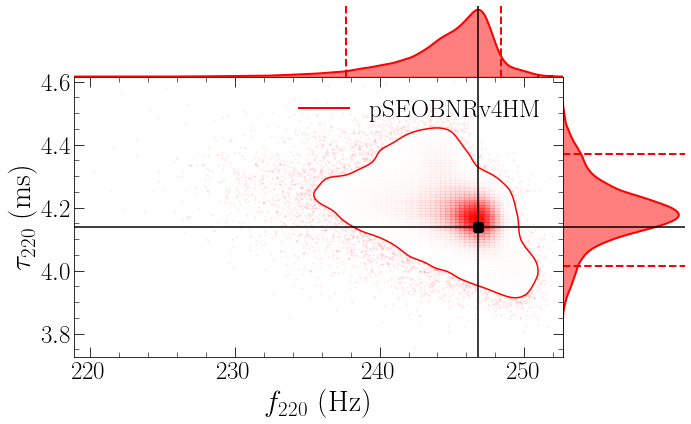

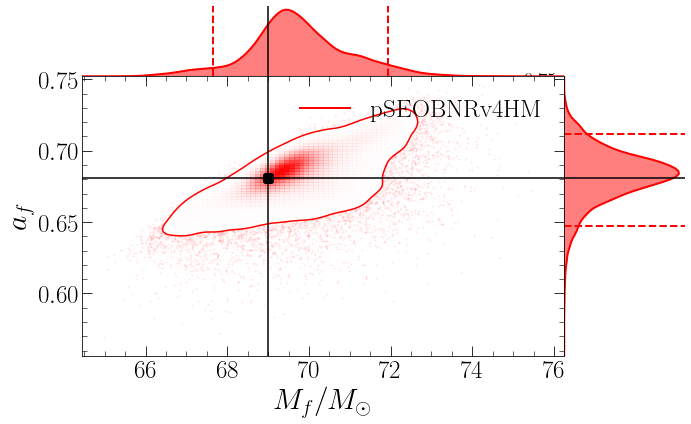

In [95]:
m1_inj, m2_inj, a1z_inj, a2z_inj = 38.528614, 33.400536, 0.003469902, -0.04400404
freq_GR_inj, tau_GR_inj, freq_modGR_inj, tau_modGR_inj = eff_quant(np.array([m1_inj]), \
                                                                   np.array([m2_inj]), \
                                                                   np.array([a1z_inj]), \
                                                                   np.array([a2z_inj]), \
                                                                   0.0, 0.0, [2,2])
Mf_inj, af_inj = Mjfinal220(2.*np.pi*freq_modGR_inj,tau_modGR_inj)

tau_GR_inj *= 1000.
tau_modGR_inj *= 1000.


print("The injected values are for freq_GR, tau_GR, freq_modGR, tau_modGR, Mf, af are: ",\
      freq_GR_inj, tau_GR_inj, freq_modGR_inj, tau_modGR_inj, Mf_inj, af_inj)

# read data
data = data_dict['GW150914']['0p0_GR']

# read out the specific columns: m1,m2,a1z,a2z,domega220,dtau220
m1, m2, a1z, a2z = data["m1"], data["m2"], data["a1z"], data["a2z"]
domega, dtau = np.zeros(len(m1)), np.zeros(len(m1))

# construct the frequencies and damping times
freq_GR, tau_GR, freq_modGR, tau_modGR = eff_quant(m1, m2, a1z, a2z, domega, dtau, [2,2])

# construct the final mass and spin
Mf, af = Mjfinal220(2.*np.pi*freq_modGR,tau_modGR)

# converty damping time samples from second to milli-second
tau_GR *= 1000.
tau_modGR *= 1000.

make_nice_plot(freq_modGR, tau_modGR, file_name='./figures/GW150914_simulated_signal_0p0_GR_f220_tau220.png',\
                   p1_bins=np.linspace(200,300,1000), \
                   p2_bins=np.linspace(2,8,1000), params=['domega220','dtau220'], \
                   p1_inj=freq_modGR_inj, p2_inj=tau_modGR_inj, color='red', label='pSEOBNRv4HM',\
                   axeslabels=['$f _{220}$ (Hz)','$\\tau _{220}$ (ms)'])

make_nice_plot(Mf, af, file_name='./figures/GW150914_simulated_signal_0p0_GR_Mfaf.png',\
                   p1_bins=np.linspace(40,100, 1000), \
                   p2_bins=np.linspace(-1,1,1000), params=['domega220','dtau220'], \
                   p1_inj=Mf_inj, p2_inj=af_inj, color='red', label='pSEOBNRv4HM',\
                   axeslabels=['$M_f/M_\odot$','$a_f$'])

### 0p5: SEOB

The injected values are for freq_GR, tau_GR, freq_modGR, tau_modGR, Mf, af are:  [246.80589509] [4.13815066] [370.20884264] [6.20722599] [65.08383884] [0.95293191]


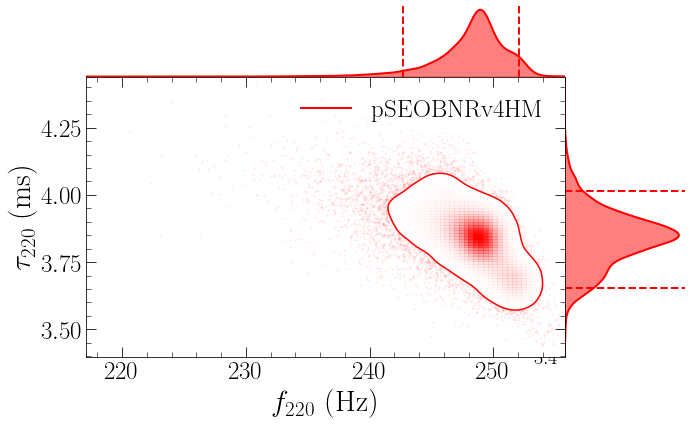

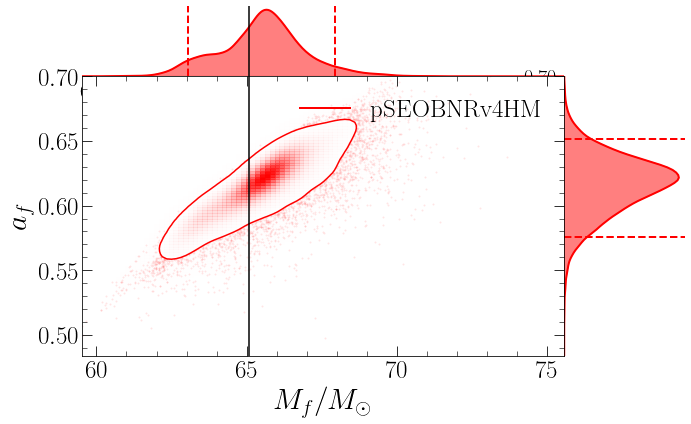

In [96]:
m1_inj, m2_inj, a1z_inj, a2z_inj = 38.528614, 33.400536, 0.003469902, -0.04400404
freq_GR_inj, tau_GR_inj, freq_modGR_inj, tau_modGR_inj = eff_quant(np.array([m1_inj]), \
                                                                   np.array([m2_inj]), \
                                                                   np.array([a1z_inj]), \
                                                                   np.array([a2z_inj]), \
                                                                   0.5, 0.5, [2,2])
Mf_inj, af_inj = Mjfinal220(2.*np.pi*freq_modGR_inj,tau_modGR_inj)

tau_GR_inj *= 1000.
tau_modGR_inj *= 1000.


print("The injected values are for freq_GR, tau_GR, freq_modGR, tau_modGR, Mf, af are: ",\
      freq_GR_inj, tau_GR_inj, freq_modGR_inj, tau_modGR_inj, Mf_inj, af_inj)

# read data
data = data_dict['GW150914']['0p5_GR']

# read out the specific columns: m1,m2,a1z,a2z,domega220,dtau220
m1, m2, a1z, a2z = data["m1"], data["m2"], data["a1z"], data["a2z"]
domega, dtau = np.zeros(len(m1)), np.zeros(len(m1))

# construct the frequencies and damping times
freq_GR, tau_GR, freq_modGR, tau_modGR = eff_quant(m1, m2, a1z, a2z, domega, dtau, [2,2])

# construct the final mass and spin
Mf, af = Mjfinal220(2.*np.pi*freq_modGR,tau_modGR)

# converty damping time samples from second to milli-second
tau_GR *= 1000.
tau_modGR *= 1000.

make_nice_plot(freq_modGR, tau_modGR, file_name='./figures/GW150914_simulated_signal_0p5_GR_f220_tau220.png',\
                   p1_bins=np.linspace(200,300,1000), \
                   p2_bins=np.linspace(2,8,1000), params=['domega220','dtau220'], \
                   p1_inj=freq_modGR_inj, p2_inj=tau_modGR_inj, color='red', label='pSEOBNRv4HM',\
                   axeslabels=['$f _{220}$ (Hz)','$\\tau _{220}$ (ms)'])

make_nice_plot(Mf, af, file_name='./figures/GW150914_simulated_signal_0p5_GR_Mfaf.png',\
                   p1_bins=np.linspace(40,100, 1000), \
                   p2_bins=np.linspace(-1,1,1000), params=['domega220','dtau220'], \
                   p1_inj=Mf_inj, p2_inj=af_inj, color='red', label='pSEOBNRv4HM',\
                   axeslabels=['$M_f/M_\odot$','$a_f$'])

[246.80589509] [4.13815066] [370.20884264] [6.20722599]


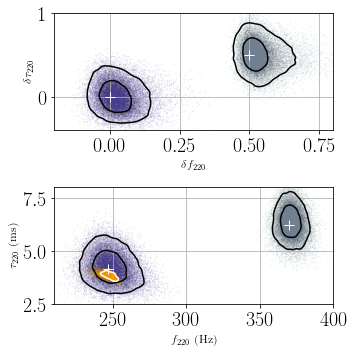

In [4]:
m1_inj, m2_inj, a1z_inj, a2z_inj = 38.528614, 33.400536, 0.003469902, -0.04400404
freq_GR_inj, tau_GR_inj, freq_modGR_inj, tau_modGR_inj = eff_quant(np.array([m1_inj]), \
                                                                   np.array([m2_inj]), \
                                                                   np.array([a1z_inj]), \
                                                                   np.array([a2z_inj]), \
                                                                   0.5, 0.5, [2,2])
tau_GR_inj *= 1000.
tau_modGR_inj *= 1000.
print(freq_GR_inj, tau_GR_inj, freq_modGR_inj, tau_modGR_inj)

fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

for (color,run) in zip(['darkslateblue','slategrey'],['0p0', '0p5']):

    # read data
    data = data_dict['GW150914'][run]

    # read out the specific columns: m1,m2,a1z,a2z,domega220,dtau220
    m1, m2, a1z, a2z, domega, dtau = data["m1"], data["m2"], data["a1z"], data["a2z"], data["domega220"], data["dtau220"]
    
    # construct the frequencies and damping times
    freq_GR, tau_GR, freq_modGR, tau_modGR = eff_quant(m1, m2, a1z, a2z, domega, dtau, [2,2])

    # converty damping time samples from second to milli-second
    tau_GR *= 1000.
    tau_modGR *= 1000.
    
    # construct 2D histogram in domega220,dtau220
    P_xy, P_x, P_y, x_intp, y_intp, s1, s2 = P_xy_2dhist(domega, dtau, N_bins=100)
    dx = np.mean(np.diff(x_intp))
    dy = np.mean(np.diff(y_intp))
    P_xy /= np.sum(P_xy) * dx * dy # normalise histogram
    
    #ax1.pcolormesh(x_intp, y_intp, gf(P_xy), cmap='Purples')
    ax1.scatter(domega, dtau, color=color, alpha=0.1, s=0.1)
    ax1.contour(x_intp, y_intp, gf(P_xy), levels=(s2,s1), colors='k')
    
    # construct 2D histogram in omega220,tau220
    P_xy, P_x, P_y, x_intp, y_intp, s1, s2 = P_xy_2dhist(freq_modGR, tau_modGR, N_bins=100)
    dx = np.mean(np.diff(x_intp))
    dy = np.mean(np.diff(y_intp))
    P_xy /= np.sum(P_xy) * dx * dy # normalise histogram

    #ax2.pcolormesh(x_intp, y_intp, gf(P_xy), cmap='Purples')
    ax2.scatter(freq_modGR, tau_modGR, color=color, alpha=0.1, s=0.1)
    ax2.contour(x_intp, y_intp, gf(P_xy), levels=(s2,s1), colors='k')

# nGR: SEOBN$v4HM
data = data_dict['GW150914']['0p5_GR']

m1, m2, a1z, a2z = data["m1"], data["m2"], data["a1z"], data["a2z"]
domega, dtau = np.zeros(len(m1)), np.zeros(len(m1))
freq_GR, tau_GR, freq_modGR, tau_modGR = eff_quant(m1, m2, a1z, a2z, domega, dtau, [2,2])

tau_GR *= 1000.
tau_modGR *= 1000.

# construct 2D histogram in omega220GR,tau220GR
P_xy, P_x, P_y, x_intp, y_intp, s1, s2 = P_xy_2dhist(freq_modGR, tau_modGR, N_bins=100)
dx = np.mean(np.diff(x_intp))
dy = np.mean(np.diff(y_intp))
P_xy /= np.sum(P_xy) * dx * dy # normalise histogram

#ax4.pcolormesh(x_intp, y_intp, gf(P_xy), cmap='Greys')
ax2.scatter(freq_modGR, tau_modGR, color='orange', alpha=0.1, s=0.1)
ax2.contour(x_intp, y_intp, gf(P_xy), levels=(s2,), colors='w')

# plot GR predictions
ax1.plot(0,0,color='w',marker='+', ms=10)
ax1.plot(0.5,0.5,color='w',marker='+', ms=10)

ax2.plot(freq_GR_inj, tau_GR_inj,color='w',marker='+', ms=10)
ax2.plot(freq_modGR_inj, tau_modGR_inj,color='w',marker='+', ms=10)

ax1.set_xlabel("$\delta f_{220}$",fontsize='large')
ax1.set_ylabel(r"$\delta \tau_{220}$", fontsize='large')
ax2.set_xlabel("$f_{220}$ (Hz)", fontsize='large')
ax2.set_ylabel(r"$\tau_{220}$ (ms)", fontsize='large') 

ax1.set_xlim([-0.2,0.8])
ax1.set_ylim([-0.4,1.])

ax2.set_xlim([210,400])
ax2.set_ylim([2.5,8])

ax1.grid()
ax2.grid()

plt.tight_layout()
plt.savefig('./figures/GW150914_simulated_signal_gr_ngr.png', dpi=300)
plt.savefig('./figures/GW150914_simulated_signal_gr_ngr.pdf', dpi=300)

## GW190521

[62.85722555] [15.53250496] [94.28583832] [23.29875745]


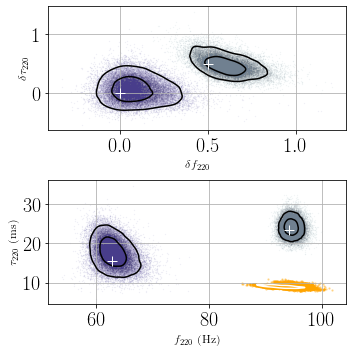

In [5]:
m1_inj, m2_inj, a1z_inj, a2z_inj = 152.599213, 120.400780, 0.02299293, -0.3864437
freq_GR_inj, tau_GR_inj, freq_modGR_inj, tau_modGR_inj = eff_quant(np.array([m1_inj]), \
                                                                   np.array([m2_inj]), \
                                                                   np.array([a1z_inj]), \
                                                                   np.array([a2z_inj]), \
                                                                   0.5, 0.5, [2,2])
tau_GR_inj *= 1000.
tau_modGR_inj *= 1000.
print(freq_GR_inj, tau_GR_inj, freq_modGR_inj, tau_modGR_inj)

fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

for (color,run) in zip(['darkslateblue','slategrey'],['0p0', '0p5']):

    # read data
    data = data_dict['GW190521'][run]

    # read out the specific columns: m1,m2,a1z,a2z,domega220,dtau220
    m1, m2, a1z, a2z, domega, dtau = data["m1"], data["m2"], data["a1z"], data["a2z"], data["domega220"], data["dtau220"]
    
    # construct the frequencies and damping times
    freq_GR, tau_GR, freq_modGR, tau_modGR = eff_quant(m1, m2, a1z, a2z, domega, dtau, [2,2])

    # converty damping time samples from second to milli-second
    tau_GR *= 1000.
    tau_modGR *= 1000.
    
    # construct 2D histogram in domega220,dtau220
    P_xy, P_x, P_y, x_intp, y_intp, s1, s2 = P_xy_2dhist(domega, dtau, N_bins=100)
    dx = np.mean(np.diff(x_intp))
    dy = np.mean(np.diff(y_intp))
    P_xy /= np.sum(P_xy) * dx * dy # normalise histogram
    
    #ax1.pcolormesh(x_intp, y_intp, gf(P_xy), cmap='Purples')
    ax1.scatter(domega, dtau, color=color, alpha=0.1, s=0.1)
    ax1.contour(x_intp, y_intp, gf(P_xy), levels=(s2,s1), colors='k')
    
    # construct 2D histogram in omega220,tau220
    P_xy, P_x, P_y, x_intp, y_intp, s1, s2 = P_xy_2dhist(freq_modGR, tau_modGR, N_bins=100)
    dx = np.mean(np.diff(x_intp))
    dy = np.mean(np.diff(y_intp))
    P_xy /= np.sum(P_xy) * dx * dy # normalise histogram

    #ax2.pcolormesh(x_intp, y_intp, gf(P_xy), cmap='Purples')
    ax2.scatter(freq_modGR, tau_modGR, color=color, alpha=0.1, s=0.1)
    ax2.contour(x_intp, y_intp, gf(P_xy), levels=(s2,s1), colors='k')

# nGR: SEOBN$v4HM
data = data_dict['GW190521']['0p5_GR']

m1, m2, a1z, a2z = data["m1"], data["m2"], data["a1z"], data["a2z"]
domega, dtau = np.zeros(len(m1)), np.zeros(len(m1))
freq_GR, tau_GR, freq_modGR, tau_modGR = eff_quant(m1, m2, a1z, a2z, domega, dtau, [2,2])

tau_GR *= 1000.
tau_modGR *= 1000.

# construct 2D histogram in omega220GR,tau220GR
P_xy, P_x, P_y, x_intp, y_intp, s1, s2 = P_xy_2dhist(freq_modGR, tau_modGR, N_bins=100)
dx = np.mean(np.diff(x_intp))
dy = np.mean(np.diff(y_intp))
P_xy /= np.sum(P_xy) * dx * dy # normalise histogram

#ax4.pcolormesh(x_intp, y_intp, gf(P_xy), cmap='Greys')
ax2.scatter(freq_modGR, tau_modGR, color='orange', alpha=0.3, s=2)
ax2.contour(x_intp, y_intp, gf(P_xy), levels=(s2,), colors='w')

# plot GR predictions
ax1.plot(0,0,color='w',marker='+', ms=10)
ax1.plot(0.5,0.5,color='w',marker='+', ms=10)

ax2.plot(freq_GR_inj, tau_GR_inj,color='w',marker='+', ms=10)
ax2.plot(freq_modGR_inj, tau_modGR_inj,color='w',marker='+', ms=10)

ax1.set_xlabel("$\delta f_{220}$",fontsize='large')
ax1.set_ylabel(r"$\delta \tau_{220}$", fontsize='large')
ax2.set_xlabel("$f_{220}$ (Hz)", fontsize='large')
ax2.set_ylabel(r"$\tau_{220}$ (ms)", fontsize='large') 

#ax1.set_xlim([-0.2,0.8])
#ax1.set_ylim([-0.4,1.])

#ax2.set_xlim([210,400])
#ax2.set_ylim([2.5,8])

ax1.grid()
ax2.grid()

plt.tight_layout()
plt.savefig('./figures/GW190521_simulated_signal_gr_ngr.png', dpi=300)
plt.savefig('./figures/GW190521_simulated_signal_gr_ngr.pdf', dpi=300)

### Example corner plot

(27612, 6)


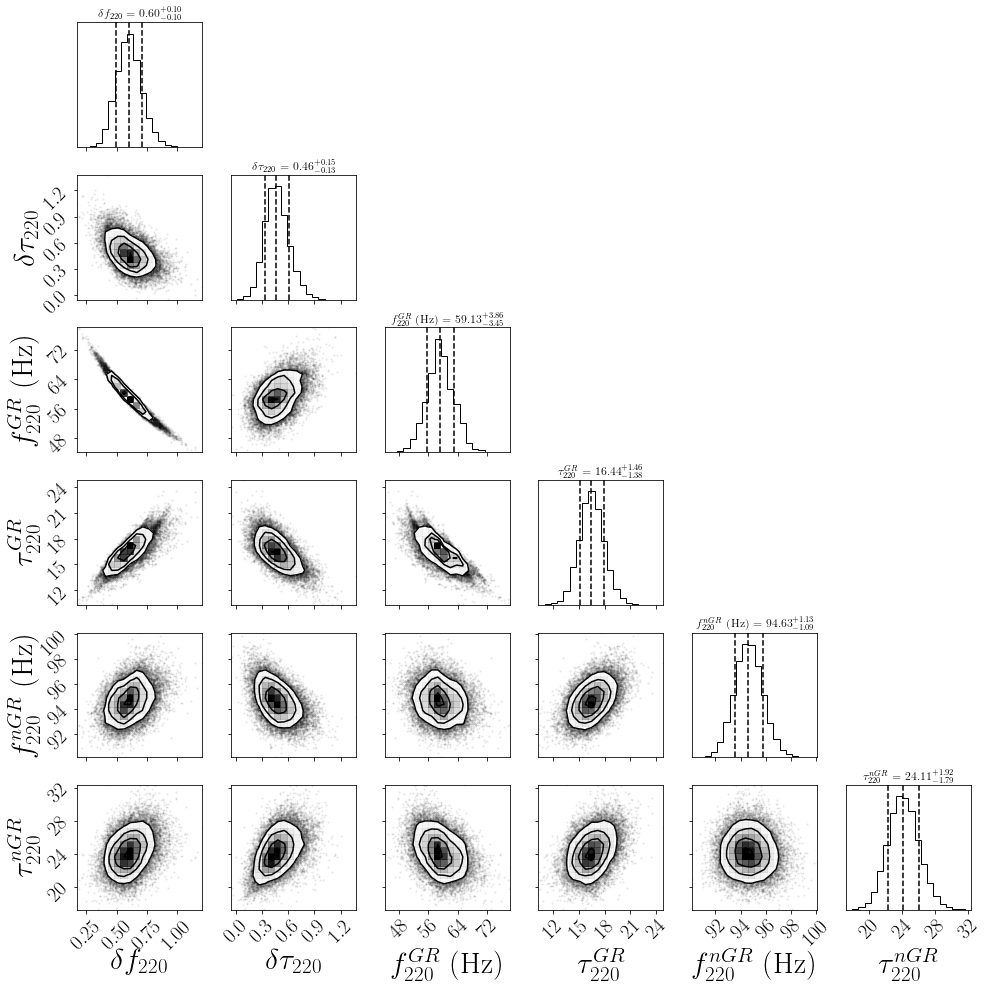

In [6]:
# nGR run for GW190521

data = data_dict['GW190521']['0p5']

m1, m2, a1z, a2z, domega, dtau = data["m1"], data["m2"], data["a1z"], data["a2z"], \
                                data["domega220"], data["dtau220"]

freq_GR, tau_GR, freq_modGR, tau_modGR = eff_quant(m1, m2, a1z, a2z, domega, dtau, [2,2])

tau_GR *= 1000.
tau_modGR *= 1000.

data_corner = np.vstack([domega, dtau, freq_GR, tau_GR, freq_modGR, tau_modGR])
data_corner = data_corner.T
print(np.shape(data_corner))

figure = corner.corner(data_corner, labels=[r"$\delta f_{220}$", r"$\delta \tau_{220}$", \
                            r"$f^{GR}_{220}$ (Hz)", r"$\tau ^{GR}_{220}$", \
                           r"$f^{nGR}_{220}$ (Hz)", r"$\tau ^{nGR}_{220}$"],
                       quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12})


plt.tight_layout()
plt.savefig('./figures/GW190521_simulated_signal_gr_corner.png', dpi=300)
plt.savefig('./figures/GW190521_simulated_signal_gr_corner.pdf', dpi=300)

## Modified GR waveforms

In [7]:
waveform_data = {}

event_list = ['GW150914']
run_list = ['0p0', '0p5']
domain_list = ['time', 'freq']
det_list = ['H1', 'L1']

for event in event_list:
    waveform_data[event] = {}
    
    for run in run_list:
        waveform_data[event][run] = {}
        
        for domain in domain_list:
            waveform_data[event][run][domain] = {}
            
            for det in det_list:
                
                data = np.loadtxt("../../runs/nonGR/%s-like/%s/%s_%sInjection.dat"%(event, run, det, domain))
                waveform_data[event][run][domain][det] = data
                
print(waveform_data)

{'GW150914': {'0p0': {'time': {'H1': array([[1.12628521e+09, 0.00000000e+00],
       [1.12628521e+09, 0.00000000e+00],
       [1.12628521e+09, 0.00000000e+00],
       ...,
       [1.12628522e+09, 0.00000000e+00],
       [1.12628522e+09, 0.00000000e+00],
       [1.12628522e+09, 0.00000000e+00]]), 'L1': array([[1.12628521e+09, 0.00000000e+00],
       [1.12628521e+09, 0.00000000e+00],
       [1.12628521e+09, 0.00000000e+00],
       ...,
       [1.12628522e+09, 0.00000000e+00],
       [1.12628522e+09, 0.00000000e+00],
       [1.12628522e+09, 0.00000000e+00]])}, 'freq': {'H1': array([[ 0.00000e+00, -4.26339e-25,  0.00000e+00],
       [ 2.50000e-01,  1.40475e-25,  4.05022e-25],
       [ 5.00000e-01,  3.37409e-25, -2.71146e-25],
       ...,
       [ 2.04750e+03,  3.91585e-27,  2.97025e-27],
       [ 2.04775e+03,  1.56785e-27, -4.65845e-27],
       [ 2.04800e+03, -4.91578e-27,  0.00000e+00]]), 'L1': array([[ 0.00000e+00,  5.42540e-25,  0.00000e+00],
       [ 2.50000e-01, -1.69114e-25, -5.17939

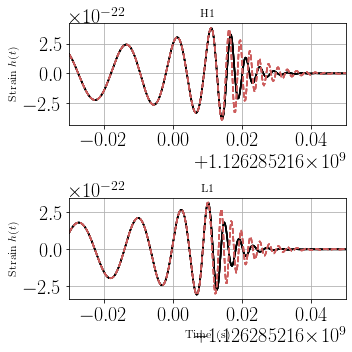

In [8]:
color_list = ['k', 'indianred']
ls_list = ['solid', 'dashed']

fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

t0 = 1126285216

for event in event_list:
    for (idx, run) in enumerate(run_list):
        for domain in domain_list:
            for det in det_list:
                
                ax1.plot(waveform_data[event][run]['time']['H1'][:,0], waveform_data[event][run]['time']['H1'][:,1], color=color_list[idx], ls=ls_list[idx])
                ax2.plot(waveform_data[event][run]['time']['L1'][:,0], waveform_data[event][run]['time']['L1'][:,1], color=color_list[idx], ls=ls_list[idx])
                
ax1.set_xlim([t0 - 0.03, t0 + 0.05]) 
ax2.set_xlim([t0 - 0.03, t0 + 0.05])  

ax1.set_ylabel('Strain $h(t)$', fontsize='large')
ax2.set_ylabel('Strain $h(t)$', fontsize='large')
ax2.set_xlabel('Time (s)', fontsize='large')

ax1.set_title('H1', fontsize='large')
ax2.set_title('L1', fontsize='large')

ax1.grid()
ax2.grid()

plt.tight_layout()
plt.savefig('./figures/modGR_waveforms.png', dpi=300)
plt.savefig('./figures/modGR_waveforms.pdf', dpi=300)

## No-hair test with SXS:BBH:0166

In [9]:
# data

post_loc_sxs_bbh_0166_220 = "../../runs/parallel_bilby/GW150914_SXS_BBH_0166_220_v2_widerprior/outdir/GW150914_checkpoint_preresult.json"
with open(post_loc_sxs_bbh_0166_220, "r") as f:
    data_sxs_bbh_0166_220 = json.load(f)
    
post_loc_sxs_bbh_0166_330 = "../../runs/parallel_bilby/GW150914_SXS_BBH_0166_330_v3_widerprior/outdir/GW150914_result.json"
with open(post_loc_sxs_bbh_0166_330, "r") as f:
    data_sxs_bbh_0166_330 = json.load(f)

NameError: name 'json' is not defined

In [ ]:
color_list = ['k', 'indianred']

fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

for (idx, data) in enumerate([data_sxs_bbh_0166_220, data_sxs_bbh_0166_330]):

    m1, m2, a1z, a2z = data['posterior']['content']['mass_1'], \
        data['posterior']['content']['mass_2'], \
        data['posterior']['content']['chi_1'], \
        data['posterior']['content']['chi_2']
    
    if data == data_sxs_bbh_0166_220:
        domega, dtau = data['posterior']['content']['domega220'], data['posterior']['content']['dtau220']
    
        m1, m2, a1z, a2z, domega, dtau = np.array(m1), np.array(m2), np.array(a1z), \
                                    np.array(a2z), np.array(domega), np.array(dtau)
    
        # construct the frequencies and damping times
        freq_GR, tau_GR, freq_modGR, tau_modGR = eff_quant(m1, m2, a1z, a2z, domega, dtau, [2,2])
        
    elif data == data_sxs_bbh_0166_330:
        domega, dtau = data['posterior']['content']['domega330'], data['posterior']['content']['dtau330']
    
        m1, m2, a1z, a2z, domega, dtau = np.array(m1), np.array(m2), np.array(a1z), \
                                    np.array(a2z), np.array(domega), np.array(dtau)
    
        # construct the frequencies and damping times
        freq_GR, tau_GR, freq_modGR, tau_modGR = eff_quant(m1, m2, a1z, a2z, domega, dtau, [3,3])
        
    print(freq_modGR,tau_modGR)

    # converty damping time samples from second to milli-second
    tau_GR *= 1000.
    tau_modGR *= 1000.
    
    # construct 2D histogram in domega220,dtau220
    P_xy, P_x, P_y, x_intp, y_intp, s1, s2 = P_xy_2dhist(domega, dtau, N_bins=100)
    dx = np.mean(np.diff(x_intp))
    dy = np.mean(np.diff(y_intp))
    P_xy /= np.sum(P_xy) * dx * dy # normalise histogram
    
    ax1.pcolormesh(x_intp, y_intp, gf(P_xy), cmap='Purples')
    ax1.scatter(domega, dtau, color=color_list[idx], alpha=0.1, s=0.1)
    ax1.contour(x_intp, y_intp, gf(P_xy), levels=(s2,s1), colors='k')
    
    # construct 2D histogram in omega220,tau220
    P_xy, P_x, P_y, x_intp, y_intp, s1, s2 = P_xy_2dhist(freq_modGR, tau_modGR, N_bins=100)
    dx = np.mean(np.diff(x_intp))
    dy = np.mean(np.diff(y_intp))
    P_xy /= np.sum(P_xy) * dx * dy # normalise histogram

    #ax2.pcolormesh(x_intp, y_intp, gf(P_xy), cmap='Purples')
    ax2.scatter(freq_modGR, tau_modGR, color=color_list[idx], alpha=0.1, s=0.1)
    ax2.contour(x_intp, y_intp, gf(P_xy), levels=(s2,s1), colors='k')

## GW150914 real event

In [ ]:
run_list = ['1sec', '3sec', '5sec', 'IMR', 'pEOB', 'pSEOB']
label_list = ['1 sec', '3 sec', '5 sec', 'IMR', 'pEOB', 'pSEOB']
loc_list = ['../data/GW150914/QNM_1ms.dat', '../data/GW150914/QNM_3ms.dat', \
            '../data/GW150914/QNM_5ms.dat', '../data/GW150914/QNM_IMR.dat', \
            '../data/GW150914/pEOB.dat', '../data/GW150914/pSEOB.dat']

data_GW150914 = {}

for (run, loc) in zip(run_list, loc_list):
    data_GW150914[run] = np.loadtxt(loc)
    
print(data_GW150914)    

In [ ]:
color_list = ['k', 'slategrey', 'lightgrey', 'darkviolet', 'deepskyblue', 'darkblue']

fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(111)

for (idx, run) in enumerate(run_list):
    
    
    freq_modGR, tau_modGR = data_GW150914[run][:,0], data_GW150914[run][:,1]
    # construct 2D histogram in omega220GR,tau220GR
    P_xy, P_x, P_y, x_intp, y_intp, s1, s2 = P_xy_2dhist(freq_modGR, tau_modGR, N_bins=100)
    
    dx = np.mean(np.diff(x_intp))
    dy = np.mean(np.diff(y_intp))
    P_xy /= np.sum(P_xy) * dx * dy # normalise histogram

    CS = ax1.contour(x_intp, y_intp, gf(P_xy), levels=(s2,), colors=color_list[idx], labels=run)
    CS.collections[0].set_label(label_list[idx])

    
    
ax1.legend(loc='upper left')
ax1.set_xlim([200, 280])     
ax1.set_ylim([1, 8])

ax1.set_xlabel("$f_{220}$ (Hz)", fontsize='large')
ax1.set_ylabel(r"$\tau_{220}$ (ms)", fontsize='large') 

ax1.grid()
plt.savefig('./figures/GW150914.png', dpi=300)
plt.savefig('./figures/GW150914.pdf', dpi=300)

# Noise Systematics

In [ ]:
# load data

data_noise = {}

run_list = ['gaussian', 'realnoise', 'realevent']

for run in run_list:
    data_noise[run] = {}

    
# loading gaussian noise data    
gaussian_noise_list = ["noise01", "noise02", "noise03", "noise04", "noise05", "zeronoise"]

for gaussian_noise in gaussian_noise_list:
    data_noise['gaussian'][gaussian_noise] = np.genfromtxt('../runs/parallel_bilby/S190521g_NRSurEXP30inj_pSEOBNRv4HM_%s/pesummary/samples/qnmtest/qnmtest_abs_params_f_tau_modGR_data.dat'%gaussian_noise, unpack=True)
    
# loading real noise data
real_noise_list = ["1242454457", "1242456257", "1242458057", "1242461657", "1242463457"]

for real_noise in real_noise_list:
    data_noise['realnoise'][real_noise] = np.genfromtxt('../runs/review/21g_injections/NRSur7dq4_MaxL_EXP30_realnoise/%s/cbcBayes/qnmtest/qnmtest_abs_params_f_tau_modGR_data.dat'%real_noise, unpack=True)

# loading data for actual event    
data_noise['realevent'] = np.genfromtxt('../runs/O3a/GW190521a/220_rererun_newpsd/cbcBayes/qnmtest/qnmtest_abs_params_f_tau_modGR_data.dat', unpack=True)

print(data_noise)

In [ ]:
label_list = ['gaussian noise', 'real detector noise', 'actual event']

fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(111)

for gaussian_noise in gaussian_noise_list:
    f, tau = data_noise['gaussian'][gaussian_noise][0,:], data_noise['gaussian'][gaussian_noise][1,:]
    P_xy, P_x, P_y, x_intp, y_intp, s1, s2 = P_xy_2dhist(f, tau*1000, N_bins=100)
    
    dx = np.mean(np.diff(x_intp))
    dy = np.mean(np.diff(y_intp))
    P_xy /= np.sum(P_xy) * dx * dy # normalise histogram

    if gaussian_noise == gaussian_noise_list[0]:
        CS = ax1.contour(x_intp, y_intp, gf(P_xy), levels=(s2,), colors='slategrey', linewidths=1, linestyles='dashdot', alpha=0.7)
        CS.collections[0].set_label(label_list[0])
    else: 
        ax1.contour(x_intp, y_intp, gf(P_xy), levels=(s2,), colors='slategrey', linewidths=1, linestyles='dashdot', alpha=0.7)
    
for real_noise in real_noise_list:
    f, tau = data_noise['realnoise'][real_noise][0,:], data_noise['realnoise'][real_noise][1,:]
    P_xy, P_x, P_y, x_intp, y_intp, s1, s2 = P_xy_2dhist(f, tau*1000, N_bins=100)
    
    dx = np.mean(np.diff(x_intp))
    dy = np.mean(np.diff(y_intp))
    P_xy /= np.sum(P_xy) * dx * dy # normalise histogram

    if real_noise == real_noise_list[0]:
        CS = ax1.contour(x_intp, y_intp, gf(P_xy), levels=(s2,), colors='darkviolet', linewidths=1, linestyles='dashdot', alpha=0.7)
        CS.collections[0].set_label(label_list[1])
    else: 
        ax1.contour(x_intp, y_intp, gf(P_xy), levels=(s2,), colors='darkviolet', linewidths=1, linestyles='dashdot', alpha=0.7)
    
f, tau = data_noise['realevent'][0,:], data_noise['realevent'][1,:]
P_xy, P_x, P_y, x_intp, y_intp, s1, s2 = P_xy_2dhist(f, tau*1000, N_bins=100)

dx = np.mean(np.diff(x_intp))
dy = np.mean(np.diff(y_intp))
P_xy /= np.sum(P_xy) * dx * dy # normalise histogram

CS = ax1.contour(x_intp, y_intp, gf(P_xy), levels=(s2,), colors='k')
CS.collections[0].set_label(label_list[2])


# plot GR predictions
ax1.plot(65,17,color='k',marker='+', ms=20)

ax1.legend(loc='upper right')

ax1.set_xlabel("$f_{220}$ (Hz)", fontsize='large')
ax1.set_ylabel(r"$\tau_{220}$ (ms)", fontsize='large') 

ax1.set_xlim([55, 85])
ax1.set_ylim([5, 45])

ax1.grid()

plt.tight_layout()
plt.savefig('./figures/S190521g_swinjs.png', dpi=300)
plt.savefig('./figures/S190521g_swinjs.pdf', dpi=300)  